In [74]:
import pandas as pd
import numpy as np
import eda
import visualization as viz
import feature_engineering as fe
import process_data as pr
import modeling as md

from sklearn.model_selection import StratifiedKFold, cross_val_score, RepeatedStratifiedKFold
from catboost import CatBoostClassifier
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFECV
import mutual_info as mi

import matplotlib.pyplot as plt
import seaborn as sns

model_number = 'catboost_hyperparameters_manual'

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

df_train.sample(3)

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
16586,16586,D,151.60,material_7,material_5,6,6,8,4,10,16.581,11.303,17.123,18.151,12.824,19.845,11.617,17.731,19.362,10.990,16.798,17.347,13.991,17.370,831.153,1
16149,16149,D,123.59,material_7,material_5,6,6,7,8,6,16.964,12.069,18.207,16.592,12.412,19.109,12.820,16.005,18.154,11.561,15.712,15.293,13.589,18.275,702.080,0
14522,14522,C,183.65,material_7,material_8,5,8,6,17,6,18.261,12.975,18.171,NaN,11.540,NaN,10.950,16.062,17.521,10.106,14.593,18.480,15.168,NaN,802.386,0


In [3]:
# Drop the id columns
dropped_columns = ['id', 'product_code']

df_train_model = df_train.drop(dropped_columns, axis=1)
df_test_model = df_test.drop(dropped_columns, axis=1)

# Assign train and test for X and y
X_train = df_train_model.drop('failure', axis=1)
y_train = df_train_model['failure']

X_test = df_test_model.copy()

In [4]:
cat_features = ['attribute_0', 'attribute_1', 'attribute_2', 'attribute_3']
continous_features = [cat for cat in X_train.columns if cat not in cat_features]

In [5]:
si = SimpleImputer(strategy='mean')
# Apply preprocessing to the training data
X_train_transformed = si.fit_transform(X_train[continous_features])
X_train_transformed = pd.DataFrame(X_train_transformed, columns=X_train[continous_features].columns)
X_train = pd.concat([X_train[cat_features], X_train_transformed], axis=1)

X_test_transformed = si.transform(X_test[continous_features])
X_test_transformed = pd.DataFrame(X_test_transformed, columns=X_test[continous_features].columns)
X_test = pd.concat([X_test[cat_features], X_test_transformed], axis=1)

X_train.head()

,attribute_0,attribute_1,attribute_2,attribute_3,loading,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
0,material_7,material_8,9,5,80.10,7.0,8.0,4.0,18.040,12.518,15.748,19.292,11.739,20.155,10.672,15.859,17.594000,15.193,15.029,16.048444,13.034,14.684,764.100
1,material_7,material_8,9,5,84.89,14.0,3.0,3.0,18.213,11.540,17.717,17.893,12.748,17.889,12.448,17.947,17.915000,11.755,14.732,15.425000,14.395,15.631,682.057
2,material_7,material_8,9,5,82.43,12.0,1.0,5.0,18.057,11.652,16.738,18.240,12.718,18.288,12.715,15.607,19.172085,13.798,16.711,18.631000,14.094,17.946,663.376
3,material_7,material_8,9,5,101.07,13.0,2.0,6.0,17.295,11.188,18.576,18.339,12.583,19.060,12.471,16.346,18.377000,10.020,15.250,15.562000,16.154,17.172,826.282
4,material_7,material_8,9,5,188.06,9.0,2.0,8.0,19.346,12.950,16.990,15.746,11.306,18.093,10.337,17.082,19.932000,12.428,16.182,12.760000,13.153,16.412,579.885


In [6]:
target = 'failure'

combined_df = pd.concat([X_train, X_test])
combined_df.sample(2)

,attribute_0,attribute_1,attribute_2,attribute_3,loading,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
1959,material_5,material_6,6,4,182.29,15.0,16.0,9.0,17.049,10.861,17.150,17.210,11.565,18.354,10.438,14.484,16.378,12.342,18.428,15.936,13.658,12.911,580.951
18756,material_7,material_5,6,6,110.87,11.0,13.0,10.0,16.796,12.885,16.271,19.268,11.433,20.362,11.903,14.396,18.099,9.809,15.293,15.270,15.097,16.033,848.943


In [7]:
X_train['loading_measurement_6'] = X_train['loading'] * X_train['measurement_6']
X_train['loading_measurement_11_ratio'] = X_train['loading'] / np.where(X_train['measurement_11'] == 0, 1e-6, X_train['measurement_11'])

X_test['loading_measurement_6'] = X_test['loading'] * X_test['measurement_6']
X_test['loading_measurement_11_ratio'] = X_test['loading'] / np.where(X_test['measurement_11'] == 0, 1e-6, X_test['measurement_11'])

In [8]:
numerical_features = X_train.select_dtypes(include=['int', 'float']).columns

In [9]:
X_test.sample(5)

,attribute_0,attribute_1,attribute_2,attribute_3,loading,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,loading_measurement_6,loading_measurement_11_ratio
4502,material_5,material_6,6,4,94.02,8.0,9.0,2.0,17.791528,10.144,16.404,17.488,11.733,20.021,11.433,16.961,19.871000,11.792,14.451,16.432000,17.330,18.451000,517.481,1644.22176,4.731518
3823,material_5,material_6,6,4,99.65,8.0,7.0,6.0,19.010000,11.214,17.986,17.501,11.918,19.469,10.553,19.599,18.992000,11.630,19.626,17.902000,9.356,16.460727,717.876,1743.97465,5.246946
3019,material_5,material_6,6,4,124.20,5.0,13.0,14.0,18.838000,12.156,16.119,16.047,10.892,19.114,12.205,19.181,17.928000,12.269,18.601,16.048444,14.663,14.890000,475.098,1993.03740,6.927711
16053,material_7,material_5,9,5,105.35,3.0,13.0,4.0,16.026000,12.392,17.932,18.612,11.409,18.601,13.772,13.936,16.200000,14.631,16.739,19.279000,13.658,14.245000,655.924,1960.77420,6.503086
11209,material_7,material_7,7,9,187.21,1.0,7.0,5.0,16.392000,11.587,15.740,18.022,13.671,18.333,10.531,14.029,19.172085,8.945,14.789,15.157000,15.084,16.036000,598.414,3373.89862,9.764718


In [10]:
X_train.shape

(26570, 25)

In [11]:
# viz.plot_catboost_feature_importance(X_train, y_train, cat_features=cat_features, figsize=(32, 32))

In [12]:
# # Create a blank DataFrame to store the results
# result_df = pd.DataFrame({'Feature': X_train.columns})

In [13]:
# # Calculate the mutual information scores 5 times
# for i in range(5):
#     mi_scores = fe.make_mi_scores_classification(X_train[numerical_features], y_train)
#     result_df[f'Run_{i + 1}'] = mi_scores['MI Score']
#     print(result_df.head(5))

In [14]:
# result_df['Average'] = result_df.iloc[:, 1:].mean(axis=1)
# result_df = result_df.sort_values(by='Average', ascending=False)
# result_df.to_csv(f'mi_result{model_number}.csv', index=False)
# result_df

In [15]:
# plt.figure(figsize=(32, 32))
# sns.barplot(
#     x=result_df['Average'],
#     y=result_df['Feature'],
# )

# plt.title('Average MI Score')
# plt.show()

In [16]:
# fi_df = pd.read_csv('feature_importance.csv')

# # Merge the DataFrames on col_a
# merged_df = fi_df.merge(result_df, on='Feature')

# # Print the merged DataFrame
# merged_df = merged_df[['Feature', 'Average_x', 'Average_y']]

# merged_df['FI_MI'] = merged_df.iloc[:, 1:].mean(axis=1, skipna=True, numeric_only=True)
# merged_df = merged_df.sort_values(by='FI_MI', ascending=False)
# merged_df

In [17]:
# # more_dropped_columns = ['attribute_2', 'measurement_2', 'measurement_7', 'measurement_12', 'measurement_16']
# more_dropped_columns = []

# # model_number = 'catboost_simpleimputer_domains'

In [18]:
# feature_list = merged_df.iloc[:25, :]['Feature'].tolist()
# feature_list

In [69]:
def get_score(hyperparameter, features):
    # For different metrics, tuning the hyperparameter and get a range for that parameter that is recorded
    model = CatBoostClassifier(random_state=hyperparameter, verbose=False)
    num_folds = 5
    cv = StratifiedKFold(n_splits=num_folds, random_state=5, shuffle=True)
    tuning_scores = cross_val_score(model, X_train[features], y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    return tuning_scores.mean()

In [20]:
# # Initialize CatBoost model
# # model = CatBoostClassifier(random_state=5, cat_features=['attribute_0', 'attribute_1','attribute_2', 'attribute_3'], verbose=False)
# model = CatBoostClassifier(random_state=5, verbose=False)

In [21]:
# rfecv = RFECV(estimator=model, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

# rfecv.fit(X_train_domain[feature_list], y_train)

In [22]:
# # Get the RFECV ranking of all the features to select which ones to use
# # Rank 1 are the features best suited for modelling but rank 2 features aren't bad
# # And so on
# rfecv_features = pd.DataFrame({'Feature': list(X_test_domain[feature_list].columns),
#                                'Ranking': rfecv.ranking_})

# rfecv_features.sort_values(by='Ranking', inplace=True)

# rfecv_features

In [23]:
# # Get the index of Rank 1 features
# selected_features = [i for i, selected in enumerate(rfecv.support_) if selected]

In [24]:
# # Get a list of the rank 1 features
# rfecv_rank_1 = list(X_train_domain[feature_list].columns[selected_features])
# rfecv_rank_1

In [70]:
rfecv_rank_1 = ['loading_measurement_11_ratio', 
                'loading_measurement_6',
                'loading']

tuning_params = [0, 5, 42]

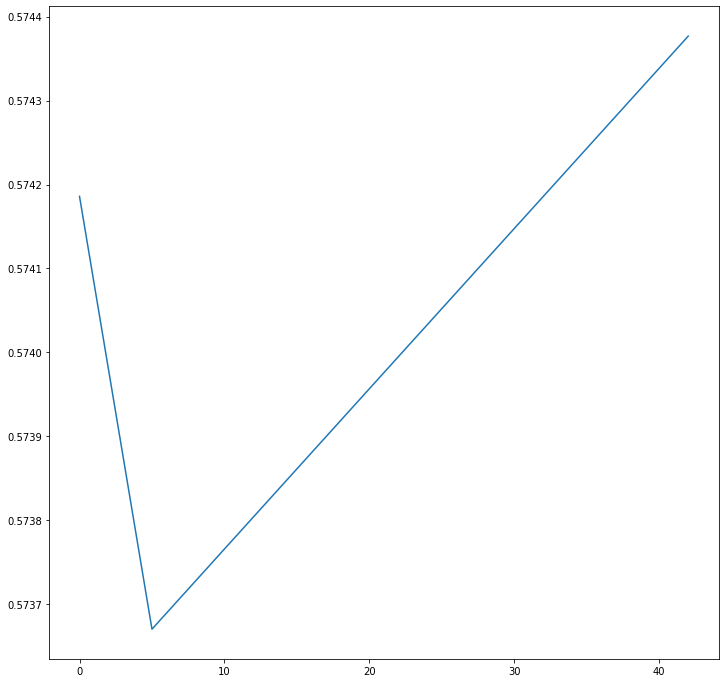

In [71]:
# Initialize an empty dictionary to store the results
results = {}

# Iterate through the learning rates and calculate scores
for param in tuning_params:
    score = get_score(param, rfecv_rank_1)
    results[param] = score

plt.figure(figsize=(12, 12))
plt.plot(list(results.keys()), list(results.values()))
plt.show()

In [72]:
model = CatBoostClassifier(random_state=42, learning_rate=0.005, depth=7, l2_leaf_reg=8, num_trees=5, subsample=0.2, verbose=False)

In [73]:
num_folds = 5
cv = StratifiedKFold(n_splits=num_folds, random_state=5, shuffle=True)

scores = cross_val_score(model, X_train[rfecv_rank_1], y_train, cv=cv, n_jobs=-1, scoring='roc_auc')

list(scores), scores.mean(), scores.std()

([0.5778462453424595,
  0.5943963730350768,
  0.5811661364828509,
  0.587687397417892,
  0.5921030812704107],
 0.586639846709738,
 0.006299157461776704)

In [ ]:
# Fit the model on the entire training data
# model.fit(X_train.drop(dropped_columns_low_fi, axis=1), y_train)
model.fit(X_train[rfecv_rank_1], y_train)

# Predict on the X_test data
# predictions = model.predict_proba(X_test.drop(dropped_columns_low_fi, axis=1))[:, 1]
predictions = model.predict_proba(X_test[rfecv_rank_1])[:, 1]

# Create a DataFrame for submission
submission_df = pd.DataFrame(
    {'id': df_test['id'],
    'failure': predictions})

# submission_df.head(50)
# Save to CSV for submission
submission_df.to_csv(f'submission_{model_number}.csv', index=False)